<a href="https://colab.research.google.com/github/JMFerret/colab/blob/main/2_stocks_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating correlated price stocks in a multi-asset basket
This notebook demonstrates how to simulate price paths in a basket containing >2 correlated assets. To achieve this, it applies [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition)  on the correlation matrix and generates an array of correlated random numbers. The notebook only serves a narrow demonstration purpose and as such lacks certain user flexiblities.

## Import libraries

In [12]:
#Import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, exp

## Set coefficient matrix
Observe that the number of stocks and the coefficient matrix $\Sigma$ are treated as constants. When adjusting manually, carefully check that the matrix dimensions align with the number of stocks and that the correlation matrix is semi-definite positive (requirement for Cholesky decomposition).

For this example, volatilies and correlation coefficients for the [Big Tech companies](https://en.wikipedia.org/wiki/Big_Tech)  over 2020 were calculated.

In [13]:
# Manually input number of stocks
NUMBER_OF_STOCKS = 5

STOCK_TICKERS = ["AAPL", "AMZN", "FB", "GOOG", "MSFT"]

VOLATILITY_ARRAY =[0.029364897425919183, 0.024211461824768903, 0.02888393105895754, 0.02410220515718577, 0.02762892161687765]

COEF_MATRIX = np.array([
    [1.0000000000000000, 0.6971648047240692, 0.7384565370708003, 0.6798703149875049, 0.6815233837805931],
    [0.6971648047240692, 1.0000000000000000, 0.8388918757956443, 0.7516701327272224, 0.7668565257541257],
    [0.7384565370708003, 0.8388918757956443, 1.0000000000000000, 0.8522010326073503, 0.7624155054902461],
    [0.6798703149875049, 0.7516701327272224, 0.8522010326073503, 1.0000000000000000, 0.8029761601663761],
    [0.6815233837805931, 0.7668565257541257, 0.7624155054902461, 0.8029761601663761, 1.0000000000000000]
])

print(COEF_MATRIX)

[[1.         0.6971648  0.73845654 0.67987031 0.68152338]
 [0.6971648  1.         0.83889188 0.75167013 0.76685653]
 [0.73845654 0.83889188 1.         0.85220103 0.76241551]
 [0.67987031 0.75167013 0.85220103 1.         0.80297616]
 [0.68152338 0.76685653 0.76241551 0.80297616 1.        ]]


## Perform Cholesky decomposition
This cell performs the Cholesky decomposition on the coefficient matrix $\Sigma$, returning a matrix $R$ that satisfies $\Sigma=R R^*$ and $R^*$ being the conjugate transpose of $R$. Note that the other computations are only for validation purposes.

In [14]:
# Perform Cholesky decomposition on coefficient matrix
R = np.linalg.cholesky(COEF_MATRIX)

# Compute transpose conjugate (only for validation)
RT = R.T.conj()

# Reconstruct coefficient matrix from factorization (only for validation)
print(np.dot(R, RT))

[[1.         0.6971648  0.73845654 0.67987031 0.68152338]
 [0.6971648  1.         0.83889188 0.75167013 0.76685653]
 [0.73845654 0.83889188 1.         0.85220103 0.76241551]
 [0.67987031 0.75167013 0.85220103 1.         0.80297616]
 [0.68152338 0.76685653 0.76241551 0.80297616 1.        ]]


## Initialize simulation properties
For simplicitly, all stocks have the same initial price $S_{n,0}$ and the same volatility $v_n$.

In [15]:
T = 252                                                  # Number of simulated days
stock_price_array = np.full((NUMBER_OF_STOCKS,T), 100.0) # Stock price, first value is simulation input 
volatility_array = VOLATILITY_ARRAY                      # Volatility (annual, 0.01=1%)
r = 0.001                                                # Risk-free rate (annual, 0.01=1%)
dt = 1.0 / T                                             # Time increment (annualized)

## Run simulation
For each time step, the cell generates a number of standard normal numbers (randomly drawn) and multiplies this with the $R$ matrix obtained from the Cholesky decomposition, yielding an epsilon array with correlated values. Mathematically, this procedure is denoted by $[\epsilon_n]_{\forall n \in \mathcal{N}} =R[x_n]_{\forall n \in \mathcal{N}}$, with $\mathcal{N}$ being the set of assets. The epsilons $\epsilon_n$ are used as inputs for the boilerplate return formula as derived from the Black-Scholes model: $S_t=S_{t-1} * e^{\left(r_f - \frac{\sigma ^2}{2}\right)}  dt + \sigma  \sqrt{dt}  \epsilon_n$

In [16]:
for t in range(1, T):
    # Generate array of random standard normal draws
    random_array = np.random.standard_normal(NUMBER_OF_STOCKS)
    
    # Multiply R (from factorization) with random_array to obtain correlated epsilons
    epsilon_array = np.inner(random_array,R)

    # Sample price path per stock
    for n in range(NUMBER_OF_STOCKS):
        dt = 1 / T 
        S = stock_price_array[n,t-1]
        v = volatility_array[n]
        epsilon = epsilon_array[n]
        
        # Generate new stock price
        stock_price_array[n,t] = S * exp((r - 0.5 * v**2) * dt + v * sqrt(dt) * epsilon)

## Plot simulated paths
With the default settings, the price paths should be highly correlated.

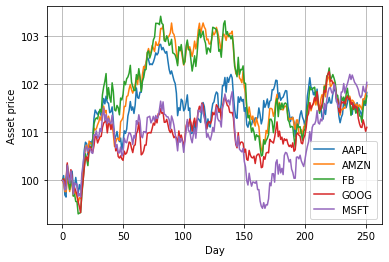

In [17]:
# Plot simulated price paths
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
array_day_plot = [t for t in range(T)]

for n in range(NUMBER_OF_STOCKS):
    ax.plot(array_day_plot, stock_price_array[n],\
                        label = '{}'.format(STOCK_TICKERS[n]))

plt.grid()
plt.xlabel('Day')
plt.ylabel('Asset price')
plt.legend(loc='best')

plt.show()